In [1]:
import datetime
import os
import random
import numpy as np
from tensorflow.keras.models import load_model
import tensorflow as tf
import mlflow.keras
from tensorflow import keras
import importlib
import joblib
import matplotlib.pyplot as plt
import seaborn as sb
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


import ml_investing_wne.config as config
from ml_investing_wne.data_engineering.load_data import get_hist_data
from ml_investing_wne.data_engineering.prepare_dataset import prepare_processed_dataset
from ml_investing_wne.train_test_val_split import train_test_val_split
from ml_investing_wne.helper import get_final_model_path, load_test_dates
from ml_investing_wne.utils import get_logger

seed = 12345
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
                   

2022-10-29 16:16:28.563445: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-29 16:16:28.563515: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
logger = get_logger()

In [3]:
df = get_hist_data(currency=config.currency)
df = prepare_processed_dataset(df=df)
X, y, X_val, y_val, X_test, y_test, y_cat, y_val_cat, y_test_cat, train = train_test_val_split(df)


2022-08-28 09:48:31,787 - ml_investing_wne.data_engineering.prepare_dataset - exported to /home/jupyter/ml_investing_wne/src/ml_investing_wne/data/processed/EURCHF/EURCHF_processed_720min.csv
2022-08-28 09:48:31,814 - ml_investing_wne.train_test_val_split - first sequence begins: 2010-01-24 12:00:00
2022-08-28 09:48:31,815 - ml_investing_wne.train_test_val_split - first sequence ends: 2010-03-25 00:00:00
2022-08-28 09:48:31,839 - ml_investing_wne.train_test_val_split - last sequence begins: 2019-10-30 12:00:00
2022-08-28 09:48:31,841 - ml_investing_wne.train_test_val_split - last sequence ends: 2019-12-30 12:00:00
2022-08-28 09:48:31,897 - ml_investing_wne.train_test_val_split - first sequence begins: 2019-11-13 12:00:00
2022-08-28 09:48:31,898 - ml_investing_wne.train_test_val_split - first sequence ends: 2020-01-14 00:00:00
2022-08-28 09:48:31,902 - ml_investing_wne.train_test_val_split - last sequence begins: 2020-10-29 12:00:00
2022-08-28 09:48:31,902 - ml_investing_wne.train_test_

In [4]:
model_name = get_final_model_path()
model = load_model(model_name)

2022-08-28 09:48:44.143801: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-28 09:48:44.143853: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-28 09:48:44.143876: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (python-20220811): /proc/driver/nvidia/version does not exist
2022-08-28 09:48:44.144116: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
y_pred = model.predict(X_test)

2022-08-28 09:48:48.043863: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [6]:
# check max probability of price going down
y_pred[:,0].max()

0.5916158

In [433]:
# list observations where model assign high probability of price going down
np.where(y_pred[:,0]>0.58)

(array([120, 142, 153, 164]),)

In [8]:
np.where(y_pred>0.6)

(array([ 44,  55,  66,  77,  88,  99, 110, 121, 132, 143, 154, 165, 176,
        187, 198, 209, 220, 231, 242, 253, 264, 275, 286, 297, 308, 330,
        341, 352, 363, 374, 385, 396, 407, 418, 429, 440, 451, 462, 473]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

In [449]:
obs= 418

In [450]:
y_pred[obs,]

array([0.39174828, 0.6082517 ], dtype=float32)

In [451]:
y_test[obs]

1

In [452]:
intermediate_layer_model = keras.Model(inputs=model.input,
                                       outputs=model.get_layer('multi_head_attention').output)

In [453]:
layer_1_output = model.layers[1](X_test[obs:obs+1,:,:])
layer_2_output = model.layers[2](layer_1_output)
layer_3_output, viz_weights = model.layers[3](layer_2_output, layer_2_output, return_attention_scores=True)

In [454]:
intermediate_layer_model(X_test[obs:obs+1,:,:])

<tf.Tensor: shape=(1, 96, 40), dtype=float32, numpy=
array([[[-0.20473665,  1.2615074 , -0.06858537, ...,  0.06822301,
         -0.68197024, -1.021252  ],
        [-0.20486006,  1.3488473 , -0.0711429 , ...,  0.09934299,
         -0.58027625, -1.135541  ],
        [-0.20260537,  1.2237903 , -0.08739393, ...,  0.06114197,
         -0.67746216, -1.0369631 ],
        ...,
        [-0.22028676,  1.6850337 ,  0.15517284, ...,  0.14098397,
         -0.5785965 , -1.0789299 ],
        [-0.23557001,  1.6975377 ,  0.2041432 , ...,  0.13340516,
         -0.62880194, -1.0238665 ],
        [-0.22815481,  1.7755088 ,  0.1684277 , ...,  0.16820218,
         -0.47903284, -1.1737472 ]]], dtype=float32)>

In [455]:
layer_3_output

<tf.Tensor: shape=(1, 96, 40), dtype=float32, numpy=
array([[[-0.20473665,  1.2615074 , -0.06858537, ...,  0.06822301,
         -0.68197024, -1.021252  ],
        [-0.20486006,  1.3488473 , -0.0711429 , ...,  0.09934299,
         -0.58027625, -1.135541  ],
        [-0.20260537,  1.2237903 , -0.08739393, ...,  0.06114197,
         -0.67746216, -1.0369631 ],
        ...,
        [-0.22028676,  1.6850337 ,  0.15517284, ...,  0.14098397,
         -0.5785965 , -1.0789299 ],
        [-0.23557001,  1.6975377 ,  0.2041432 , ...,  0.13340516,
         -0.62880194, -1.0238665 ],
        [-0.22815481,  1.7755088 ,  0.1684277 , ...,  0.16820218,
         -0.47903284, -1.1737472 ]]], dtype=float32)>

In [456]:
viz_weights

<tf.Tensor: shape=(1, 4, 96, 96), dtype=float32, numpy=
array([[[[0.00558218, 0.00519085, 0.00551162, ..., 0.01221723,
          0.01317874, 0.01109962],
         [0.00361077, 0.00298008, 0.00338772, ..., 0.01009044,
          0.01258259, 0.00834804],
         [0.00551044, 0.00528676, 0.00550125, ..., 0.01290302,
          0.01319252, 0.01174835],
         ...,
         [0.00265865, 0.00212697, 0.00240239, ..., 0.01153666,
          0.0134912 , 0.00866173],
         [0.00318333, 0.00261436, 0.00290008, ..., 0.01485337,
          0.01698349, 0.0119407 ],
         [0.00128924, 0.00088986, 0.0010885 , ..., 0.00920776,
          0.01289941, 0.00638628]],

        [[0.0067101 , 0.00700689, 0.00656853, ..., 0.01130142,
          0.0113426 , 0.01183085],
         [0.00492346, 0.00416595, 0.00473995, ..., 0.01046732,
          0.01293505, 0.00939742],
         [0.00599646, 0.00623723, 0.00584545, ..., 0.01142033,
          0.01158885, 0.01196663],
         ...,
         [0.00642165, 0.00517764

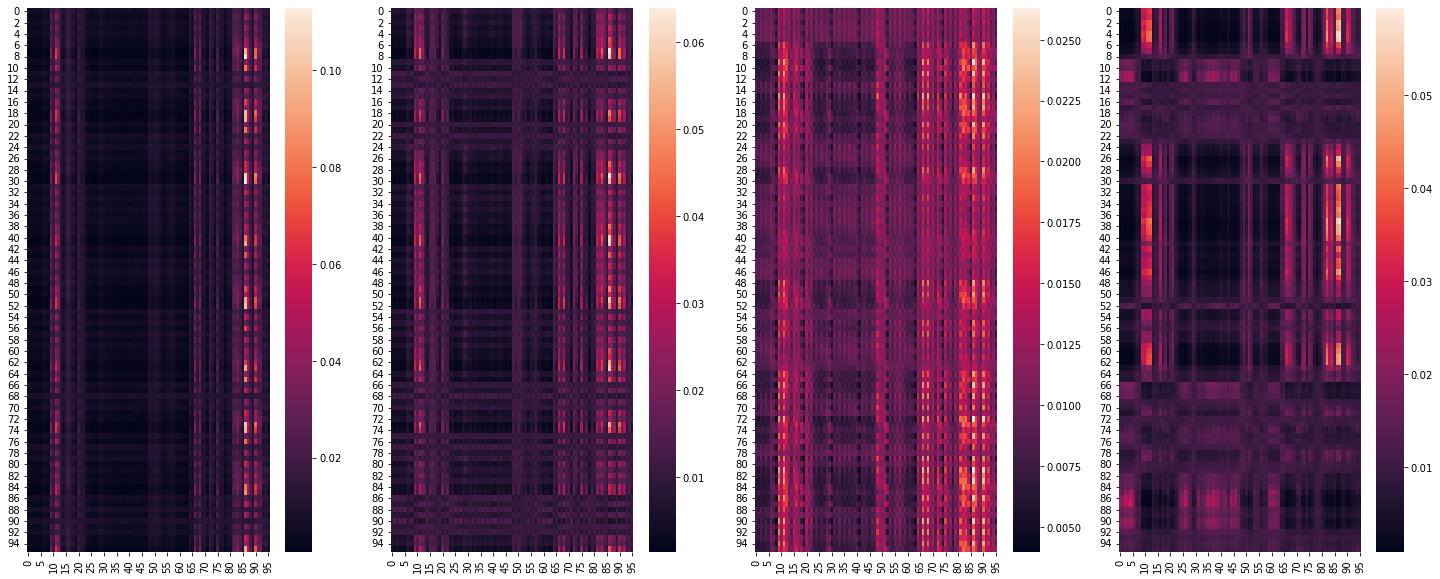

In [457]:
figure, axes = plt.subplots(1, 4, figsize=(25, 10))
index = 0
for i, axis in enumerate(axes):
    sb.heatmap(viz_weights[0, i, :, :], linewidth=0, ax=axis)
    index = index+1
plt.show()


In [458]:
average_score_per_day = {}
for i in range(viz_weights.shape[1]):
    average_score = np.mean(viz_weights[0, i, :, :].numpy(), axis=0)
    average_score_per_day['head_{}'.format(i)] = average_score

In [459]:
start_date, end_date = load_test_dates()

In [460]:
prediction = df.loc[(df.datetime >= start_date) & (df.datetime <= end_date)]

In [461]:
prediction.reset_index(inplace=True, drop=True)

In [462]:
sequence = prediction.iloc[(obs-config.seq_len+1):obs+3,:].reset_index(drop=True)

In [463]:
sequence.shape

(98, 42)

In [431]:
colors = ['green','blue','orange','yellow']

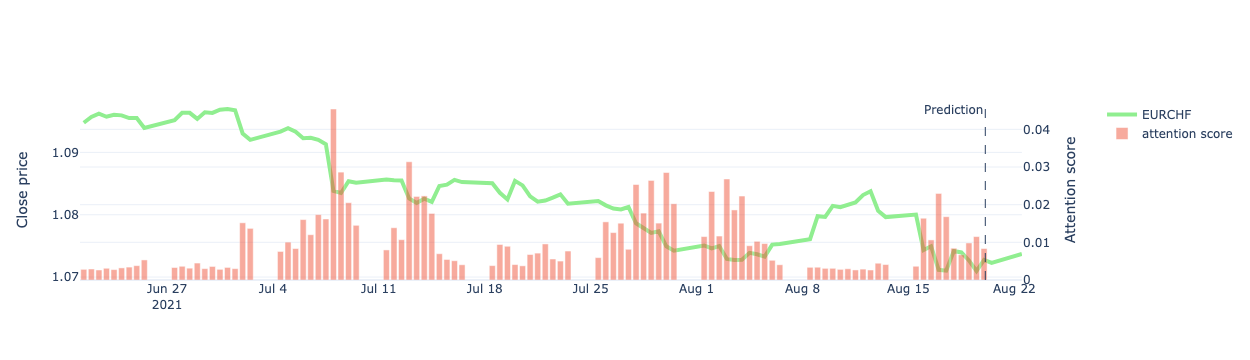

In [432]:

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.update_layout(template='plotly_white')
fig.add_trace(go.Scatter(x=sequence['datetime'], y=sequence['close'], name='EURCHF',
                    line=dict(color='lightgreen', width=4)))
fig.add_trace(go.Bar(x=sequence['datetime'], y=average_score_per_day['head_0'], name='attention score',opacity=0.5), secondary_y=True)
fig.add_vline(x=sequence.iloc[config.seq_len-1,:]['datetime'].timestamp() * 1000, line_width=1, line_dash="dash", 
              annotation_text="Prediction", annotation_position="top left")
fig.update_yaxes(title_text="Close price", secondary_y=False)
fig.update_yaxes(title_text='Attention score', secondary_y=True)


In [409]:
specs=[[{"secondary_y": True}, {} ],[{"secondary_y": True}, {} ], [{"secondary_y": True}, {} ], [{"secondary_y": True}, {} ]]

In [410]:
specs_short=[[{"secondary_y": True}, {} ]]

In [403]:
colorbar_position = [0.9, 0.62, 0.35, 0.1]

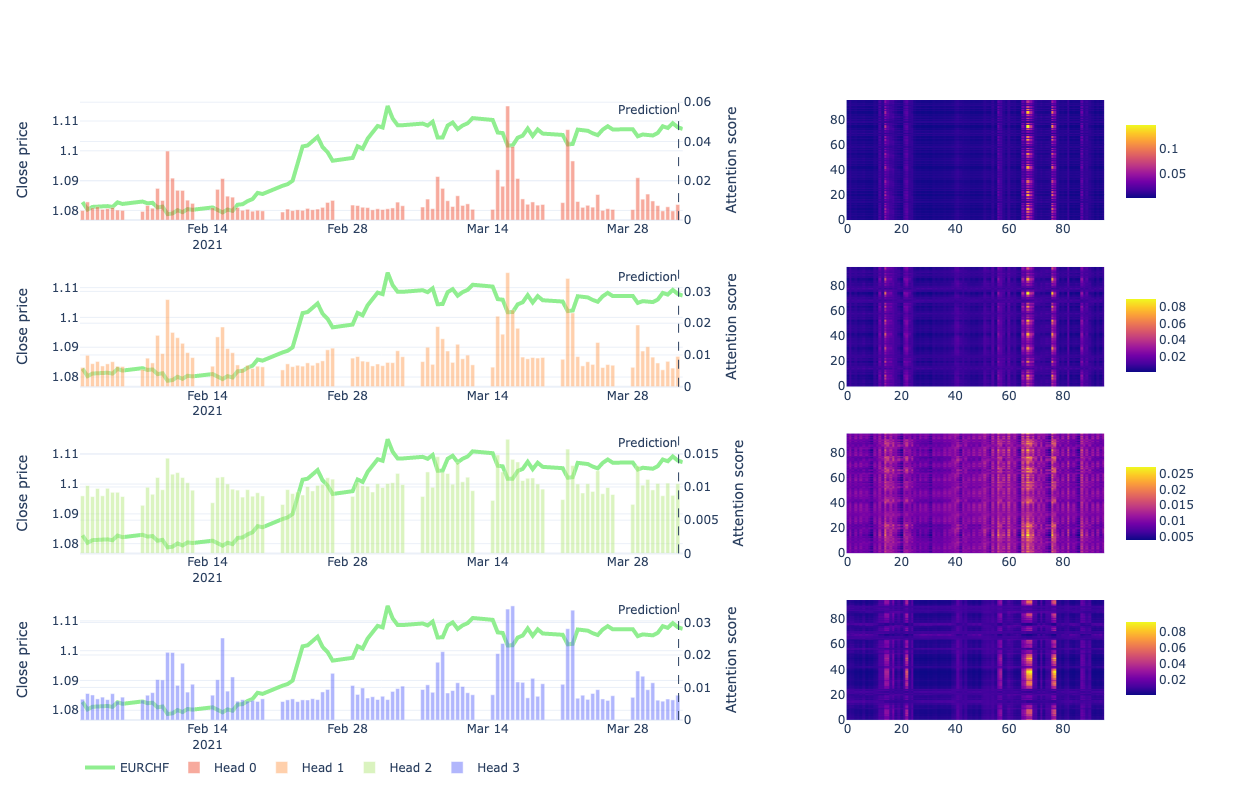

In [404]:
fig = make_subplots(rows=4, cols=2, specs=specs, column_widths=[0.7, 0.3], horizontal_spacing = 0.15)
fig.update_layout(template='plotly_white', width=1200, height=800) #  showlegend=False

for i, head in enumerate(average_score_per_day):

    if i==0:
        fig.add_trace(go.Scatter(x=sequence['datetime'], y=sequence['close'], name='EURCHF', 
                            line=dict(color='lightgreen', width=4)), row=i+1, col=1)
    else: 
        fig.add_trace(go.Scatter(x=sequence['datetime'], y=sequence['close'], showlegend = False,
                        line=dict(color='lightgreen', width=4)), row=i+1, col=1)
    fig.add_trace(go.Bar(x=sequence['datetime'], y=average_score_per_day[head] ,opacity=0.5, name='Head {}'.format(i)), secondary_y=True, row=i+1, col=1)
    fig.add_vline(x=sequence.iloc[config.seq_len-1,:]['datetime'].timestamp() * 1000, line_width=1, line_dash="dash", 
                  annotation_text="Prediction", annotation_position="top left", row=i+1, col=1)
    fig.update_yaxes(title_text="Close price", secondary_y=False, row=i+1, col=1)
    fig.update_yaxes(title_text='Attention score', secondary_y=True, row=i+1, col=1)

    fig.add_trace(go.Heatmap(
                       z=viz_weights[0, i, :, :],
                       hoverongaps = False, colorbar={"len": 0.15}, colorbar_y=colorbar_position[i], colorbar_x=0.95), row=i+1, col=2)
    
    fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=-0.1,
    x=0
))

fig.show()
fig.write_image(os.path.join(config.package_directory, 'models','attention_obs_{}.png'.format(obs)))

head_0
head_1
head_2
head_3


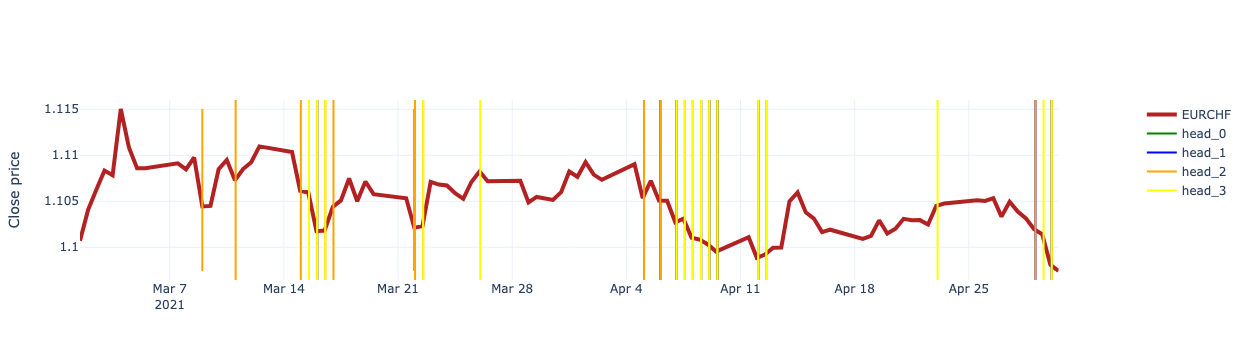

In [200]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
y_min = sequence['close'].min()
y_max = sequence['close'].max()

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.update_layout(template='plotly_white')
fig.add_trace(go.Scatter(x=sequence['datetime'], y=sequence['close'], name='EURCHF',
                    line=dict(color='firebrick', width=4)))
for color, head in enumerate(head_attentions):
    print(head)
    for i, row in enumerate(head_attentions[head]):
        if i == 0:
            fig.add_trace(go.Scatter(x=[sequence.iloc[row,:]['datetime'],sequence.iloc[row,:]['datetime']] , 
                             y=[y_min,y_max], 
                             mode='lines', 
                             line=dict(color=colors[color], width=2),
                             name=head))
        else:
            fig.add_vline(x=sequence.iloc[row,:]['datetime'].timestamp() * 1000, line_width=2, line_color=colors[color])
        

fig.update_yaxes(title_text="Close price", secondary_y=False)


head_0


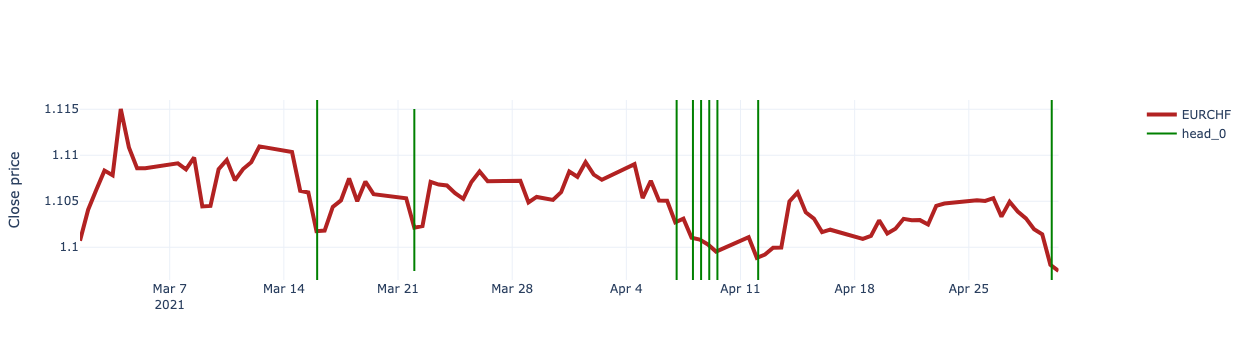

head_1


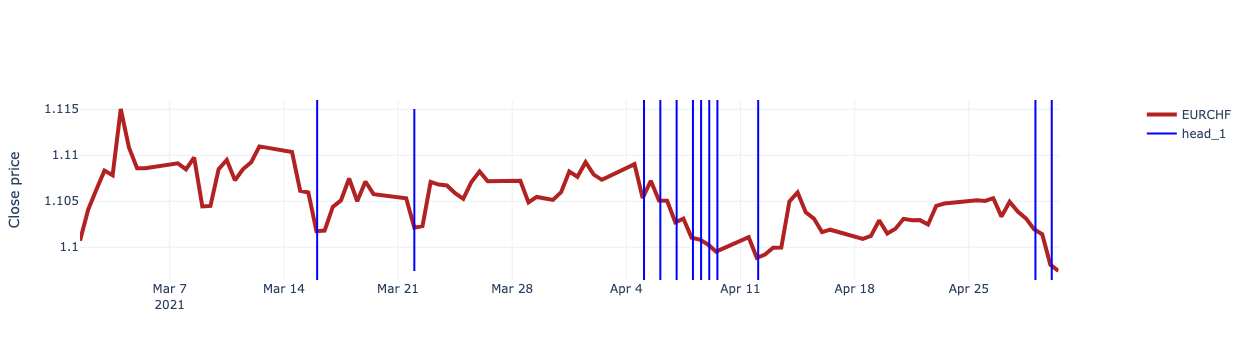

head_2


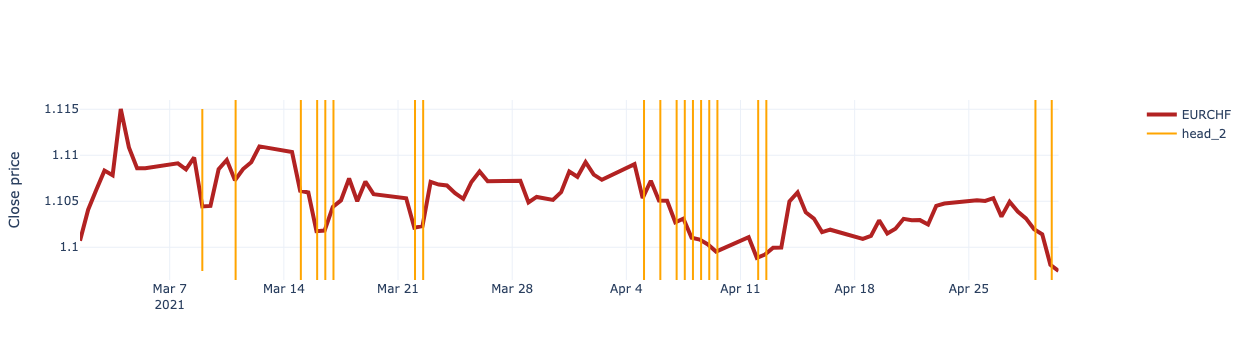

head_3


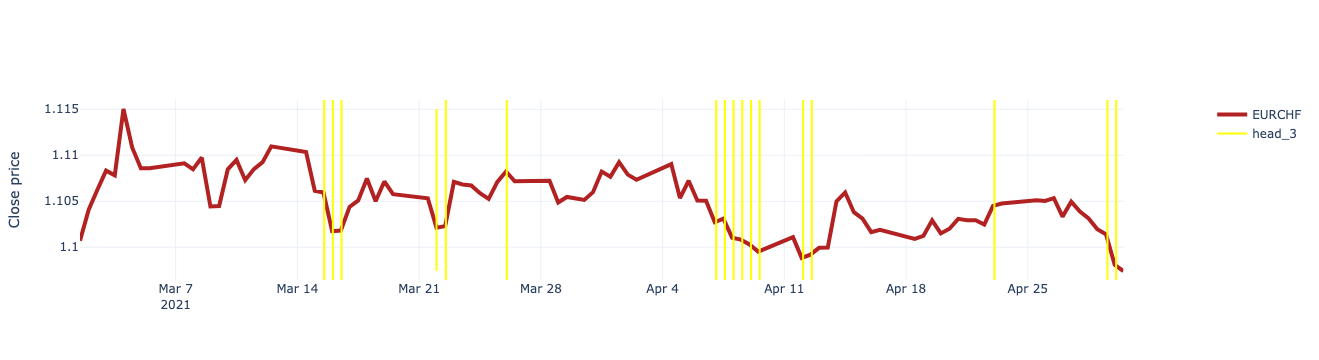

In [201]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
y_min = sequence['close'].min()
y_max = sequence['close'].max()

for color, head in enumerate(head_attentions):
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.update_layout(template='plotly_white')
    fig.add_trace(go.Scatter(x=sequence['datetime'], y=sequence['close'], name='EURCHF',
                        line=dict(color='firebrick', width=4)))

    print(head)
    for i, row in enumerate(head_attentions[head]):
        if i == 0:
            fig.add_trace(go.Scatter(x=[sequence.iloc[row,:]['datetime'],sequence.iloc[row,:]['datetime']] , 
                             y=[y_min,y_max], 
                             mode='lines', 
                             line=dict(color=colors[color], width=2),
                             name=head))
        else:
            fig.add_vline(x=sequence.iloc[row,:]['datetime'].timestamp() * 1000, line_width=2, line_color=colors[color])
        

    fig.update_yaxes(title_text="Close price", secondary_y=False)
    fig.show()

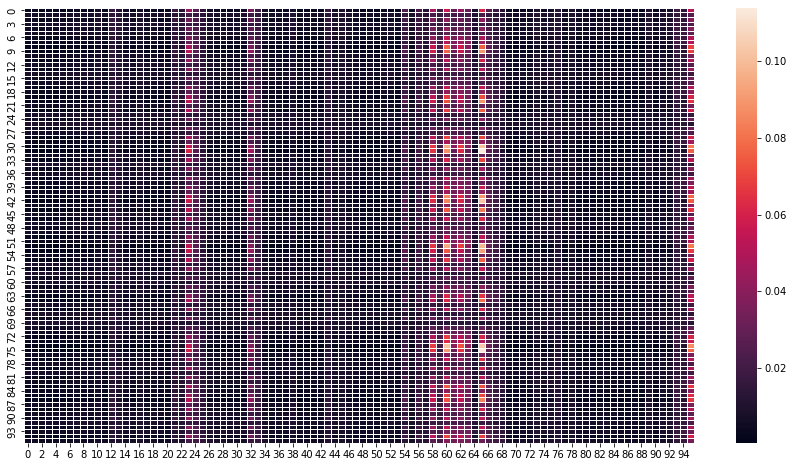

In [202]:
plt.figure(figsize=(15,8))
ax = sb.heatmap(viz_weights[0, 0, :, :], linewidth=0.5)
plt.show()

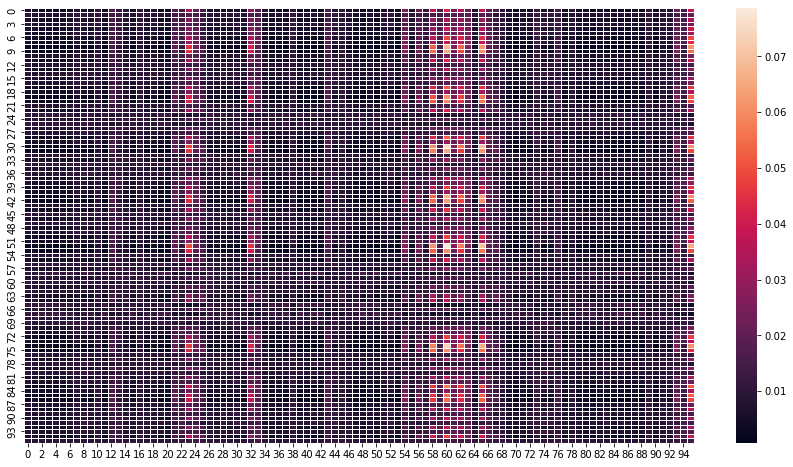

In [203]:
plt.figure(figsize=(15,8))
ax = sb.heatmap(viz_weights[0, 1, :, :], linewidth=0.5)
plt.show()

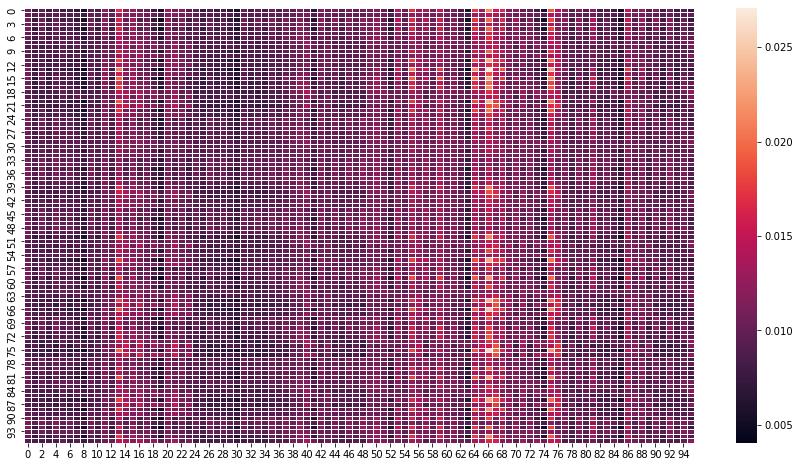

In [176]:
plt.figure(figsize=(15,8))
ax = sb.heatmap(viz_weights[0, 2, :, :], linewidth=0.5)
plt.show()

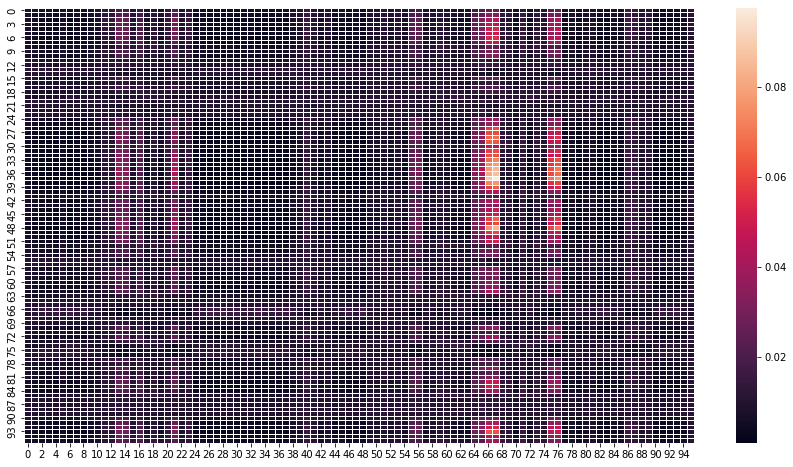

In [177]:
plt.figure(figsize=(15,8))
ax = sb.heatmap(viz_weights[0, 3, :, :], linewidth=0.5)
plt.show()